# Spark at design time example DAG
## A notebook describing the routines used in the DAG

In [1]:
# import into the notebook a bunch of stuff that may get used
import functools
from datetime import datetime, timedelta
from airflow import DAG
from airflow.operators.bash_operator import BashOperator
from airflow.operators.python_operator import PythonOperator
from dss_airflow_utils.spark import SparkOperator
from dss_airflow_utils.dag_factory import dag_factory, SparkConfig, DagConfig
from dss_airflow_utils.workspace_utils import path_in_workspace
from dss_airflow_utils.utils import get_config
from dss_datacache_client import client
import fastparquet
import pyspark
import pandas as pd

[2019-03-01 00:46:29,377] {settings.py:174} INFO - settings.configure_orm(): Using pool settings. pool_size=5, pool_recycle=1800, pid=489


The next function is used to generate a row of data that has a constant value in the first column and increasing randomness as you go across the rows.  Thus for our tests we can generate rows that are all different but also all recognizable.

In [2]:
import random

def increasing_rand(rownum, avg=0, low=0, high=0, size=1):
    if size <= 0 or low > avg or avg > high:
        raise RangeException

    retval = list([avg] * size)
    incr_up = (high - avg) / (size - 1)
    incr_dn = (avg - low) / (size - 1)
    up = down = 0
    for i, _ in enumerate(retval):
        retval[i] += random.triangular(down, up, 0)
        up += incr_up
        down -= incr_dn
    return retval


Looking for a nice functional way to generate the row I create a version of the function that has all the variables set except the row number.

In [3]:
size = 100
avg = 128.0
low = 0.0
high = 255.0
this_rand = functools.partial(increasing_rand,
                              avg=avg, low=low,
                              high=high, size=size)

Now I create the noise dataset as a python array (list of lists) by calling map

In [4]:
noise_dataset = map(this_rand, range(size))

Now we can pass the python array to panda's DataFrame constructor and get back a dataframe.  I then ask for the mean of the medians of all the rows.  It should be close to the defined average in the generation function, 128.0

In [5]:
df = pd.DataFrame(noise_dataset)
pd.Series([df[i].median() for i in range(df.shape[0])]).mean()

127.51656441275465

Average looks good.  We can also look at the python array with matplotlib.


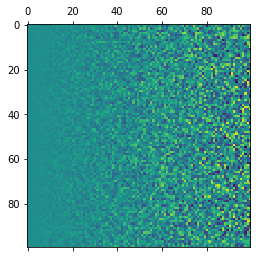

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Display matrix
plt.matshow(noise_dataset)
plt.show()


When the dag runs, it creates the data and a log message is written to record where it went.  Now I can read it back.  This probably won't work when you, reader, because the /shared directory is intended to be used to pass data files from one DAG task to another and therefore gets cleaned out regularly.  If you run the DAG, copy the filename it gives you in the log. You can then subsitute the file name below and get the data into this notebook.

In [97]:
df100 = pd.read_parquet('/shared/taste_spark_size_at_design_0_0_0_probare_2018-08-23T01-14-53.067621/structured_noise.parquet')

Now we can plot the data from the parquet file to show that it is the same sort of data.

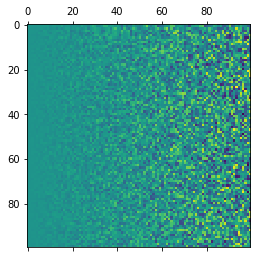

In [98]:
plt.matshow(df100.get_values())
plt.show()